In [1]:
"""
Recreate Woo et al paper (almost) exactly

Author: Alan Nguyen

10-07-2020

fits
"""

'\nRecreate Woo et al paper (almost) exactly\n\nAuthor: Alan Nguyen\n\n10-07-2020\n\nfits\n'

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, Column
from scipy.optimize import curve_fit, leastsq
from scipy.stats import spearmanr
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u
import os
import math as m
from astropy import constants as const
import time
from BOSS_func_v9 import *
from general_functions_v1 import *
import matplotlib.patches as mpatches

In [3]:
hdul = fits.open('recreate_woo/gal_info_zbin3.fits')

zbin3_data = hdul[1].data

hdul.close()

In [4]:
specs ={}
count = 0

for row in zbin3_data:
    
    try:
        ######################################### set up file directories

        PLATE = '{:04}'.format(row['PLATEID'])
        MJD   = str(row['MJD'])
        FIBER = '{:03}'.format(row['FIBERID'])
        key_list = ['spSpec',MJD, PLATE, FIBER]
        key = '-'.join(key_list)
        filename = key + '.fit'
        folder = 'woo_zbin3_specs'

        directory = os.path.join(folder, filename)

        #########################################

        z = row['Z']
        k = 1 + z

        #########################################

        hdul = fits.open(directory) #using above directory open fits for the specific spectra

        header = hdul[0].header
        data   = hdul[0].data

        hdul.close()

        #########################################

        fluxden = data[0]

        COEFF0 = header['COEFF0']
        COEFF1 = header['COEFF1']

        wave = np.zeros(len(fluxden))

        for i in range(len(wave)):
            wave[i] = 10 ** (COEFF0 + COEFF1 * i)

        #########################################

        error = data[2]

        #########################################

        tempdat = [] #temporary list to hold each dataset before adding it to the dictionary

        #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
        tempdat.append(wave)    #0 
        tempdat.append(fluxden) #1
        tempdat.append(k)       #2
        tempdat.append(error)   #3

        specs.update({key:tempdat})

        ###############################
        ###############################

        count += 1
        print("\r" + "Complete: {}/{}".format(count,len(zbin3_data)), end = "") #progress bar to keep track of progress
    except:
        print(' darn')

Complete: 3/5306 darn
 darn
 darn
 darn
Complete: 38/5306 darn
 darn
 darn
 darn
 darn
Complete: 49/5306 darn
 darn
 darn
 darn
 darn
Complete: 55/5306 darn
 darn
 darn
 darn
 darn
Complete: 56/5306 darn
 darn
 darn
 darn
Complete: 73/5306 darn
 darn
 darn
Complete: 89/5306 darn
 darn
 darn
 darn
Complete: 91/5306 darn
 darn
 darn
 darn
 darn
Complete: 106/5306 darn
 darn
Complete: 112/5306 darn
 darn
 darn
 darn
 darn
 darn
Complete: 124/5306 darn
 darn
Complete: 126/5306 darn
 darn
 darn
Complete: 142/5306 darn
Complete: 193/5306 darn
 darn
 darn
Complete: 203/5306 darn
Complete: 211/5306 darn
Complete: 278/5306 darn
 darn
 darn
Complete: 303/5306 darn
 darn
 darn
 darn
Complete: 307/5306 darn
 darn
 darn
 darn
Complete: 328/5306 darn
 darn
 darn
Complete: 334/5306 darn
 darn
 darn
 darn
 darn
 darn
 darn
Complete: 340/5306 darn
Complete: 341/5306 darn
 darn
Complete: 343/5306 darn
 darn
 darn
 darn
 darn
 darn
 darn
 darn
 darn
 darn
 darn
 darn
 darn
 darn
 darn
 darn
Complete: 351

In [5]:
#
#bring down the size of the dictionary to create a smaller working dictionary, trimmed just for the [OIII]5007 line
#

trimmed_specs = {}

count = 0 #for a loading bar lmao

bad_specs = []

for key in specs: #for every spectrum generated in previous block
    wave = specs[key][0] #extract wavelength array
    fluxden = specs[key][1] #extract flux density array
    k = specs[key][2] #z + 1, to account for redshift during the trimming
    error = specs[key][3] #extract flux density error array
    
    ###############################
    ###############################

    OIII_select = (wave > 4980*k) & (wave < 5030*k) #create parameter to trim the data for the [OIII]5007 line

    OIII_wave = wave[OIII_select] #select for [OIII]5007
    OIII_fluxden = fluxden[OIII_select] #select for [OIII]5007
    OIII_error = error[OIII_select] #select for [OIII]5007
    
    ###############################
    ###############################
    
    inf_indices = np.where(OIII_error == np.inf) #take indices where error is infinity for some reason?
    
    mean_error = np.mean(OIII_error[OIII_error != np.inf]) #take the mean error from the [OIII]5007 slice
    
    for i in inf_indices[0]: #replace all the infinity indices with the mean error
        OIII_error[i] = mean_error
    
    ###############################
    ###############################
    
    OIII_fluxden_scale = np.max(OIII_fluxden) #take the scale factor as the maximum flux density in this region
    
    OIII_norm_fluxden = OIII_fluxden / OIII_fluxden_scale #normalize so the peak is at one
    OIII_norm_error = OIII_error / OIII_fluxden_scale #scale the error to preserve relationship with flux density
    
    ###############################
    ###############################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(OIII_wave)          #0 wavelength
    tempdat.append(OIII_norm_fluxden)  #1 normalized flux density
    tempdat.append(k)                  #2 k = z + 1
    tempdat.append(OIII_norm_error)    #3 normalized flux density error
    tempdat.append(OIII_fluxden_scale) #4 maximum flux density used to scale normalized flux density
    
    trimmed_specs.update({key:tempdat}) #update the trimmed dictionary with a smaller dataset
    
    ###############################
    ###############################
    
    if OIII_fluxden_scale == 0: #add to list of "flat" spectra
        bad_specs.append(key)
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(specs)), end = "") #progress bar to keep track of progress
    
    ###############################
    ###############################
    
for s in bad_specs: #remove bad spectra from the trimmed dictionary
    trimmed_specs.pop(key, None)

Complete: 5103/5103

In [7]:
for key in trimmed_specs:
    error = trimmed_specs[key][3]
    
    mean_error = np.mean(error)
    
    for i in range(len(error)):
        if error[i] == 0:
            error[i] = mean_error

In [8]:
AN_specs = {}

for key in trimmed_specs:
    
    OIII_wave    = trimmed_specs[key][0] #array with wavelength values for the current spectrum in angstrom
    OIII_fluxden = trimmed_specs[key][1] #array with corresponding flux density values
    k            = trimmed_specs[key][2]
    OIII_error   = trimmed_specs[key][3] 
    
    ye = np.where(OIII_wave == 5007*k)
    distance_to_center = np.zeros(len(OIII_wave))
    
    for i in range(len(OIII_wave)):
        distance_to_center[i] = np.abs(OIII_wave[i] - 5007*k)
    
    center_index = np.where(distance_to_center == np.min(distance_to_center))[0][0]
    center_flux  = OIII_fluxden[center_index]
    center_error = OIII_error[center_index]
    
    AN = center_flux / center_error

    AN_specs.update({key:AN})

for key in AN_specs:
    if AN_specs[key] < 5:
        trimmed_specs.pop(key, None)


In [9]:
############################### here is the initial run with all specs
###############################


preset_parameters = {} #called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID, fit
TRIALS = 100 #set number of trials for the Monte-Carlo error
MC_flags = np.zeros((TRIALS, len(trimmed_specs)))
count = 0
final_results = {}
start_time = time.process_time()
negative_amp_fits = []

for key in trimmed_specs: #loop and use the fit on all the trimmed specs
    
    used_preset = False #by default use the generic initial conditions

    OIII_wave    = trimmed_specs[key][0] #array with wavelength values for the current spectrum in angstrom
    OIII_fluxden = trimmed_specs[key][1] #array with corresponding flux density values
    k            = trimmed_specs[key][2] #corresponding z + 1 value
    OIII_error   = trimmed_specs[key][3] #array with corresponding flux density error values
    
    ###############################
    ###############################
    
    specific_presets = {} #prepare a dictionary with velocity means corrected for the current spectrum's k value

    for p in preset_parameters: #for every key in the preset parameters
        
    ###############################
    ###############################
        
        k_corrected_parameters = preset_parameters[p][0] #take the parameters first 
        
    ###############################
    
#     Using z = v / c
    
#     z1 / v1 = c = z2 / v2
    
#     v2 = (z2 / z1) * v1
    
#     z2 = k_spectrum - 1

#     z1 = k_fit - 1
    
    ###############################
        
        k_corrected_parameters[1] = ((k - 1)/(preset_parameters[p][1] - 1)) * k_corrected_parameters[1]
        k_corrected_parameters[4] = ((k - 1)/(preset_parameters[p][1] - 1)) * k_corrected_parameters[4]
        
    ###############################
#   
    
#     Sometimes get a problem with the above
    
#   
    ###############################
        
        #if the angstrom value of the mean is not within the wavelength range, then bring it back into the range for both means
        if to_angstrom_OIII(k_corrected_parameters[1]) >= OIII_wave[-1] or to_angstrom_OIII(k_corrected_parameters[1]) <= OIII_wave[0]:
            k_corrected_parameters[1] = (k - 1) * 300000
         
        if to_angstrom_OIII(k_corrected_parameters[4]) >= OIII_wave[-1] or to_angstrom_OIII(k_corrected_parameters[4]) <= OIII_wave[0]:
            k_corrected_parameters[4] = (k - 1) * 300000
            
        #if it turns out that both are not in the range, make generic velocity means and keep widths and amplitudes
        if k_corrected_parameters[1] == k_corrected_parameters[4]:
            k_corrected_parameters[1] = to_vel_OIII(5007*k)
            k_corrected_parameters[4] = identify_wing(OIII_wave, OIII_fluxden, k)
        
        specific_presets.update({p:k_corrected_parameters}) #update the specific presets dictionary with the k corrected velocity means
    
    if len(preset_parameters) == 0: #this is for the first iteration
        similarity_table = np.zeros(shape = (1, 9)) #make a single row with [0] the rcsq, [1:8] parameters, filled with zeros
        similarity_table[0][0] = np.inf #set the rcsq value to infinity to force generic parameters because there are no presets to try
        
    else:
        similarity_table = np.zeros(shape = (len(preset_parameters), 9)) #create empty array to store rcsq and parameters used to generate them
    
    ###############################
    ###############################
    
    #generate initial parameters
    
    ###############################
    ###############################
    
    double_gaussian_parameters = double_gauss_params(OIII_wave, OIII_fluxden, k) #generate generic parameters
    
    parameters_counter = 0 #used to loop down the similarity table
    
    for p in specific_presets: #try to see if can get better starting parameters from the previously done spectra
        
        similarity1 = np.sum(((OIII_fluxden - double_gaussian_lincont(OIII_wave, specific_presets[p])) / OIII_error) ** 2) #take csq between current data in iteration and fits from preset
        similarity2 = similarity1 / len(OIII_fluxden) #divide by length for reduced chi squared
                                        
        similarity_table[parameters_counter][0] = similarity2 #parameters_counter gives row, first entry is the similiarity2, rcsq for the current parameters being tested
        similarity_table[parameters_counter][1::] = specific_presets[p] #set the rest of the row to the parameters used to generate the similarity2, rcsq
        parameters_counter += 1

    best_rcsq = np.min(similarity_table[:,0]) #identify the lowest value in the first column, the best rcsq
    
    ###############################
    ###############################
    
    initial_conditions = np.zeros(shape = (1, 8)) #make an empty array with enough space to hold the 8 parameters
    
    ###############################
    ###############################
    
    try: #will almost always use this
        if best_rcsq <= 20: #arbitrary guess, seems to give lowest average rcsq

            used_preset = True #note that a preset was used, do not update the dictionary with this fit
            
            initial_conditions = similarity_table[np.where(similarity_table[:,0] == best_rcsq)][0][1::] #find the row corresponding to the lowest rcsq value and set the initial conditions to those parameters

        else:
            initial_conditions = double_gaussian_parameters #if the best rcsq isn't lower than 40 (again, arbitrary guess) then force the generic parameters
    
    except: #iterations with a 0 length preset parameters may run into an error, force generic parameters in that case
        initial_conditions = double_gaussian_parameters
    
    ###############################
    ###############################

    MC_params = np.zeros((TRIALS, 9))
    
    ###############################
    ###############################ERROR IN PARAMETERS
    
    results = []
    
    for r in range(TRIALS): #create a fit for every row of MC_params, number of TRIALS
        iter_dat = np.random.normal(OIII_fluxden, OIII_error) #fluctuate the data using the given error
        iter_dat = iter_dat.astype('float32') #change data type so it works lol

        fit_params = leastsq(double_gaussian_lincont_fit, x0 = initial_conditions, args = (OIII_wave, iter_dat, OIII_error), maxfev = 100000) #fit the iteration data using the same initial parameters
        MC_params[r][0:8] = fit_params[0] #set the first 8 columns with the parameters
        iter_flag = flag_spec(fit_params, OIII_wave, iter_dat, OIII_error) #flag the iteration fit
        MC_params[r][8] = iter_flag #give the 9th column the iteration flag
        
    for i in range(8): #now loop over the first 8 columns
        results.append(np.mean(MC_params[:,i]))
        results.append(np.std(MC_params[:,i]))
    
    final_params = np.array(results)
    #0 amplitude1               8 velocity_mean2
    #1 amplitude1_error         9 velocity_mean2_error
    #2 velocity_mean1          10 velocity_width2
    #3 velocity_mean1_error    11 velocity_width2_error
    #4 velocity_width1         12 linear_slope
    #5 velocity_width1_error   13 linear_slope_error
    #6 amplitude2              14 linear_yintercept
    #7 amplitude2_error        15 linear_yintercept_error
    
    MC_flags[:,count] = MC_params[:,8]
    
#     final_params = np.array([final_params[0::2], 0])
#     final_flag = flag_spec(final_params, OIII_wave, OIII_fluxden, OIII_error)
    
    ###############################
    ###############################
    
    fit_params = leastsq(double_gaussian_lincont_fit, x0 = initial_conditions, args = (OIII_wave, OIII_fluxden, OIII_error), maxfev = 100000) #call the least squares fit using which ever initial conditions were used
    
    params = fit_params[0] #take only the parameters
     
#     fit = double_gaussian_lincont(OIII_wave, params) #generate y values for the fit
    
#     csq = np.sum(((OIII_fluxden - double_gaussian_lincont(OIII_wave, params)) / OIII_error) ** 2) #take csq between current data in iteration and fits from preset
#     rcsq = csq / len(OIII_fluxden) #divide by length for reduced chi squared
    
    ###############################
    ###############################
    
    #Here we check for bad data, mostly negative amplitude
    
    flag_fit = flag_spec(fit_params, OIII_wave, OIII_fluxden, OIII_error)
    
    ###############################
    ###############################
    
    if used_preset == False and flag_fit != 0: #if a preset was not used and it was not flagged bad_data, then update a new preset in the dictionary with this fit 
        preset_parameters.update({key:[params, k]}) #0 fit parameters, 1 k value
    
    ###############################
    ###############################
    
    if flag_fit == 0:
        negative_amp_fits.append([key,count])
    
    final_error = final_params[1::2]
    
    final_results_params = np.zeros(16)
    final_results_params[0:8]  = params
    final_results_params[8:16] = final_error
    
    final_results.update({key:final_results_params})
    
    count += 1
    print("\r" + "Complete: {}".format(count), end = "")
    
print(" ")
print("Runtime: {}s".format((time.process_time() - start_time)))
    


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:447: RuntimeWarning: Number of calls to function has reached maxfev = 100000.
  warnings.warn(errors[info][0], RuntimeWarning)


Complete: 5041 
Runtime: 104042.984375s


In [10]:
len(preset_parameters)

756

In [11]:
len(negative_amp_fits)

755

In [12]:
############################### here is the second run with the bad fits, now constrained with only positive parameters
###############################

#all the leastsq fitting lines need to be replaced by bounded curve_fit but only for the negative amps
#try using previous presets with bounded curvefit

# preset_parameters = {} #called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID, fit
TRIALS = 100 #set number of trials for the Monte-Carlo error
# MC_flags_2 = np.zeros((TRIALS, len(negative_amp_fits)))
count = 0
# final_results = {}
start_time = time.process_time()

for _ in negative_amp_fits: #loop and use the fit on all the trimmed specs
    
    key = _[0]
    MC_column = _[1]
    
    used_preset = False #by default use the generic initial conditions

    OIII_wave    = trimmed_specs[key][0] #array with wavelength values for the current spectrum in angstrom
    OIII_fluxden = trimmed_specs[key][1] #array with corresponding flux density values
    k            = trimmed_specs[key][2] #corresponding z + 1 value
    OIII_error   = trimmed_specs[key][3] #array with corresponding flux density error values
    
    OIII_wave    = np.float64(OIII_wave)
    OIII_fluxden = np.float64(OIII_fluxden)
    OIII_error   = np.float64(OIII_error)
    
    ###############################
    ###############################
    
    specific_presets = {} #prepare a dictionary with velocity means corrected for the current spectrum's k value

    for p in preset_parameters: #for every key in the preset parameters
        
    ###############################
    ###############################
        
        k_corrected_parameters = preset_parameters[p][0] #take the parameters first 
        
    ###############################
    ###############################
        
        k_corrected_parameters[1] = ((k - 1)/(preset_parameters[p][1] - 1)) * k_corrected_parameters[1]
        k_corrected_parameters[4] = ((k - 1)/(preset_parameters[p][1] - 1)) * k_corrected_parameters[4]
        
    ###############################
#   
    
#     Sometimes get a problem with the above
    
#   
    ###############################
        
        #if the angstrom value of the mean is not within the wavelength range, then bring it back into the range for both means
        if to_angstrom_OIII(k_corrected_parameters[1]) >= OIII_wave[-1] or to_angstrom_OIII(k_corrected_parameters[1]) <= OIII_wave[0]:
            k_corrected_parameters[1] = (k - 1) * 300000
         
        if to_angstrom_OIII(k_corrected_parameters[4]) >= OIII_wave[-1] or to_angstrom_OIII(k_corrected_parameters[4]) <= OIII_wave[0]:
            k_corrected_parameters[4] = (k - 1) * 300000
            
        #if it turns out that both are not in the range, make generic velocity means and keep widths and amplitudes
        if k_corrected_parameters[1] == k_corrected_parameters[4]:
            k_corrected_parameters[1] = to_vel_OIII(5007*k)
            k_corrected_parameters[4] = identify_wing(OIII_wave, OIII_fluxden, k)
        
        specific_presets.update({p:k_corrected_parameters}) #update the specific presets dictionary with the k corrected velocity means
    
    if len(preset_parameters) == 0: #this is for the first iteration
        similarity_table = np.zeros(shape = (1, 9)) #make a single row with [0] the rcsq, [1:8] parameters, filled with zeros
        similarity_table[0][0] = np.inf #set the rcsq value to infinity to force generic parameters because there are no presets to try
        
    else:
        similarity_table = np.zeros(shape = (len(preset_parameters), 9)) #create empty array to store rcsq and parameters used to generate them
    
    ###############################
    ###############################
    
    # generate initial parameters
    
    ###############################
    ###############################
    
    double_gaussian_parameters = double_gauss_params(OIII_wave, OIII_fluxden, k) #generate generic parameters
    
    parameters_counter = 0 #used to loop down the similarity table
    
    for p in specific_presets: #try to see if can get better starting parameters from the previously done spectra
        
        similarity1 = np.sum(((OIII_fluxden - double_gaussian_lincont(OIII_wave, specific_presets[p])) / OIII_error) ** 2) #take csq between current data in iteration and fits from preset
        similarity2 = similarity1 / len(OIII_fluxden) #divide by length for reduced chi squared
                                        
        similarity_table[parameters_counter][0] = similarity2 #parameters_counter gives row, first entry is the similiarity2, rcsq for the current parameters being tested
        similarity_table[parameters_counter][1::] = specific_presets[p] #set the rest of the row to the parameters used to generate the similarity2, rcsq
        parameters_counter += 1

    best_rcsq = np.min(similarity_table[:,0]) #identify the lowest value in the first column, the best rcsq
    
    ###############################
    ###############################
    
    initial_conditions = np.zeros(shape = (1, 8)) #make an empty array with enough space to hold the 8 parameters
    
    ###############################
    ###############################
    
    try: #will almost always use this
        if best_rcsq <= 20: #arbitrary guess, seems to give lowest average rcsq

            used_preset = True #note that a preset was used, do not update the dictionary with this fit
            
            initial_conditions = similarity_table[np.where(similarity_table[:,0] == best_rcsq)][0][1::] #find the row corresponding to the lowest rcsq value and set the initial conditions to those parameters

        else:
            initial_conditions = double_gaussian_parameters #if the best rcsq isn't lower than 40 (again, arbitrary guess) then force the generic parameters
    
    except: #iterations with a 0 length preset parameters may run into an error, force generic parameters in that case
        initial_conditions = double_gaussian_parameters
    
    ###############################
    ###############################

    MC_params = np.zeros((TRIALS, 9))
    
    ###############################
    ############################### ERROR IN PARAMETERS
    
    results = []
    
    for r in range(TRIALS): #create a fit for every row of MC_params, number of TRIALS
        iter_dat = np.random.normal(OIII_fluxden, OIII_error) #fluctuate the data using the given error
        iter_dat = np.float64(iter_dat) #change data type so it works lol
        try:
            popt, pcov = curve_fit(double_gaussian_lincont_curvefit, OIII_wave, iter_dat, initial_conditions, OIII_error, bounds = ((0, -np.inf, -np.inf, 0, -np.inf, -np.inf, -np.inf, -np.inf), (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)), method = 'trf', maxfev = 500000)
        except:
            popt, pcov = curve_fit(double_gaussian_lincont_curvefit, OIII_wave, iter_dat, double_gaussian_parameters, OIII_error, bounds = ((0, -np.inf, -np.inf, 0, -np.inf, -np.inf, -np.inf, -np.inf), (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)), method = 'trf', maxfev = 500000)
        MC_params[r][0:8] = popt #set the first 8 columns with the parameters
        iter_flag = flag_spec([popt], OIII_wave, iter_dat, OIII_error) #flag the iteration fit
        MC_params[r][8] = iter_flag #give the 9th column the iteration flag
        
    for i in range(8): #now loop over the first 8 columns
        results.append(np.mean(MC_params[:,i]))
        results.append(np.std(MC_params[:,i]))
    
    final_params = np.array(results)    
    #0 amplitude1               8 velocity_mean2
    #1 amplitude1_error         9 velocity_mean2_error
    #2 velocity_mean1          10 velocity_width2
    #3 velocity_mean1_error    11 velocity_width2_error
    #4 velocity_width1         12 linear_slope
    #5 velocity_width1_error   13 linear_slope_error
    #6 amplitude2              14 linear_yintercept
    #7 amplitude2_error        15 linear_yintercept_error
    

    MC_flags[:, MC_column] = MC_params[:,8]
    
#     final_params = np.array([final_params[0::2], 0])
#     final_flag = flag_spec(final_params, OIII_wave, OIII_fluxden, OIII_error)
    
#     print(final_params)

    ###########################
    ###########################
    
    try:
        popt, pcov = curve_fit(double_gaussian_lincont_curvefit, OIII_wave, iter_dat, initial_conditions, OIII_error, bounds = ((0, -np.inf, -np.inf, 0, -np.inf, -np.inf, -np.inf, -np.inf), (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)), method = 'trf', maxfev = 500000)
    except:
        popt, pcov = curve_fit(double_gaussian_lincont_curvefit, OIII_wave, iter_dat, double_gaussian_parameters, OIII_error, bounds = ((0, -np.inf, -np.inf, 0, -np.inf, -np.inf, -np.inf, -np.inf), (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)), method = 'trf', maxfev = 500000)
    params = popt #take only the parameters
     
#     fit = double_gaussian_lincont(OIII_wave, params) #generate y values for the fit
    
#     csq = np.sum(((OIII_fluxden - double_gaussian_lincont(OIII_wave, params)) / OIII_error) ** 2) #take csq between current data in iteration and fits from preset
#     rcsq = csq / len(OIII_fluxden) #divide by length for reduced chi squared
    
    ###############################
    ###############################
    
    #Here we check for bad data, mostly negative amplitude
    
#     flag_fit = flag_spec(fit_params, OIII_wave, OIII_fluxden, OIII_error)
    
    #unnecessary as all specs are bad lmao
    
    ###############################
    ###############################
    
    if used_preset == False: #if a preset was not used and it was not flagged bad_data, then update a new preset in the dictionary with this fit 
        preset_parameters.update({key:[params, k]}) #0 fit parameters, 1 k value
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}".format(count), end = "")
    
    final_error = final_params[1::2]
    
    final_results_params = np.zeros(16)
    final_results_params[0:8]  = params
    final_results_params[8:16] = final_error

    final_results.update({key:final_results_params})

    
    

print(" ")
print("Runtime: {}s".format((time.process_time() - start_time)))
    


Complete: 755 
Runtime: 4892.71875s


In [13]:
############################### add flags to final_results
###############################

for key in final_results:
    parameters = final_results[key]
    
    wave = trimmed_specs[key][0]
    fluxden = trimmed_specs[key][1]
    model = final_results[key][0:8]
    error = trimmed_specs[key][3]
    
    flag = flag_spec(np.array([model]), wave, fluxden, error)
    
    parameters_and_flag = [parameters, flag]
    
    final_results.update({key:parameters_and_flag})

In [14]:
final_results_2 = {}

In [15]:
############################### here we check for single gaussian preapre to refit with a single gaussian model
###############################

for key in trimmed_specs:
    try:
        wave = trimmed_specs[key][0]
        fluxden = trimmed_specs[key][1]
        model = final_results[key][0][0:8]
        error = trimmed_specs[key][3]

        flag = final_results[key][1]

        if flag == 2 or flag == 3:

            component1 = final_results[key][0][0:3]
            component2 = final_results[key][0][3:6]

            amp_component1 = component1[0]
            amp_component2 = component2[0]

            if amp_component1 < amp_component2:
                min_component = component1
            else:
                min_component = component2

            min_component_plot = gaussian(wave, min_component)

            # take the lower of the two amplitudes to compare with the noise level at that index

            min_component_amp = np.max(min_component_plot)

            amp_component_index = np.where(min_component_plot == min_component_amp)

            AN_min_component = min_component_amp / error[amp_component_index]

            if (len(AN_min_component) > 1):
                flag = 1
            elif (AN_min_component < 3):
                flag = 1

        final_results_2.update({key:[final_results[key][0], flag]})
    except:
        print('bruh')
    
#     if flag == 2 or flag == 3:
#         plt.plot(wave, min_component_plot)
#         plt.plot(wave, error)
#         plt.show()
#         plt.clf()
#         print(AN_min_component)

In [16]:
final_results_3 = {}

In [17]:
for key in trimmed_specs:
    try:
        wave = trimmed_specs[key][0]
        fluxden = trimmed_specs[key][1]
        error = trimmed_specs[key][3]

        flag = final_results_2[key][1]

        if flag == 2 or flag == 3:

            model = final_results_2[key][0]

            vel_core       = model[2]
            vel_core_error = model[10]

            vel_wing       = model[5]
            vel_wing_error = model[11]

            vel_outflow = vel_core - vel_wing

            if np.abs(vel_outflow) < np.sqrt( vel_core_error ** 2 + vel_wing_error ** 2 ):
                flag = 4

        final_results_3.update({key:[final_results_2[key][0], flag]})
    except:
        print('bruh')

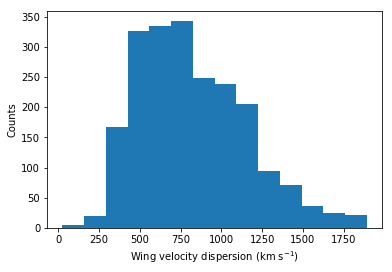

In [18]:
wing_vel_dis_list = []

for key in final_results_3:
    flag = final_results_3[key][1]
    
    if flag == 2 or flag ==3:
        
        model = final_results_3[key][0][0:8]
        core_wing = wing_check(model)
        wing_vel_dis = core_wing[1][2]

        wing_vel_dis_list.append(wing_vel_dis)

wing_vel_dis_array = np.array(wing_vel_dis_list)

plt.hist(wing_vel_dis_array, bins = 14)

plt.xlabel(r'Wing velocity dispersion (km s$^{-1}$)')
plt.ylabel('Counts')

# plt.savefig('zbin1_wingveldis_hist.png')

plt.show()

In [19]:
def single_gauss_params(wave, fluxden, k): #(wavelength array, fluxden array, k = 1 + z)
    amp_OIII = amp_gauss(wave, fluxden)
    
    amp = 11 * amp_OIII / 12
    z = k - 1
    v = z * 300000
    vel_sigma = 141
    
    ####################

    m = (fluxden[-1] - fluxden[0]) / (wave[-1] - wave[0])
    b = (m * -wave[0]) + fluxden[0]
    
    return [amp, v, vel_sigma, m, b]

In [20]:
############################### here is the run to refit all the single gaussians
###############################


# preset_parameters_single = {} #called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID, fit
TRIALS = 100 #set number of trials for the Monte-Carlo error
# MC_flags = np.zeros((TRIALS, len(trimmed_specs)))
count = 0

start_time = time.process_time()
# negative_amp_fits = []

for key in final_results_3: #loop and use the fit on all the trimmed specs
    
    flag = final_results_3[key][1]
    
    if flag == 1:

        OIII_wave    = trimmed_specs[key][0] #array with wavelength values for the current spectrum in angstrom
        OIII_fluxden = trimmed_specs[key][1] #array with corresponding flux density values
        k            = trimmed_specs[key][2] #corresponding z + 1 value
        OIII_error   = trimmed_specs[key][3] #array with corresponding flux density error values
        
        OIII_wave    = np.float64(OIII_wave)
        OIII_fluxden = np.float64(OIII_fluxden)
        OIII_error   = np.float64(OIII_error)
        
        MC_params = np.zeros((TRIALS, 6))

        ###############################
        ###############################ERROR IN PARAMETERS
        
        single_gaussian_parameters = single_gauss_params(OIII_wave, OIII_fluxden, k)
        
        results = []

        for r in range(TRIALS): #create a fit for every row of MC_params, number of TRIALS
            iter_dat = np.random.normal(OIII_fluxden, OIII_error) #fluctuate the data using the given error
            iter_dat = iter_dat.astype('float64') #change data type so it works lol

            fit_params = leastsq(single_gaussian_lincont_fit, x0 = single_gaussian_parameters, args = (OIII_wave, iter_dat, OIII_error), maxfev = 100000) #call the least squares fit using which ever initial conditions were used
            params = fit_params[0] #take only the parameters
            
            MC_params[r][0:5] = params #set the first 5 columns with the parameters
            
        for i in range(5): #now loop over the first 8 columns
            results.append(np.median(MC_params[:,i]))
            results.append(np.std(MC_params[:,i]))

        pre_final_params = np.array(results)
        
        final_params = np.zeros(16)

        ###############################
        ###############################
        
        fit_params = leastsq(single_gaussian_lincont_fit, x0 = single_gaussian_parameters, args = (OIII_wave, OIII_fluxden, OIII_error), maxfev = 100000) #call the least squares fit using which ever initial conditions were used
        params = fit_params[0] #take only the parameters

        ###############################
        ###############################
        
        final_params[0:3]   = pre_final_params[0:6][0::2]
        final_params[6:8]   = pre_final_params[6:10][0::2]

        final_params[8:11]  = pre_final_params[0:6][1::2]
        final_params[14:16] = pre_final_params[6:10][1::2]
        
        final_results_3.update({key:[final_params, flag]})
        
        count += 1
        print("\r" + "Complete: {}".format(count), end = "")
        
print(" ")
print("Runtime: {}s".format((time.process_time() - start_time)))
    


Complete: 2365 
Runtime: 318.765625s


In [21]:
###############RUN CELLS UP TO HERE FOR LATEST RESULTS

In [22]:
flags = []
for key in final_results_3:
    flag = final_results_3[key][1]
    flags.append(flag)
flags = np.array(flags) #convert the list into an array for faster processing
unique, counts = np.unique(flags, return_counts=True) #count occurences of each flag
classifications = dict(zip(unique, counts)) #put into dictionary
print(classifications) #print the dictionary to view the wing values

{0: 9, 1: 2365, 2: 1550, 3: 588, 4: 529}


In [23]:
try:
    bad_data_mean   = (100 * classifications[0]) / len(final_results_3)

    no_outflow_mean = (100 * ( classifications[1] + classifications[4]) ) / len(final_results_3)

    blu_wing_mean   = (100 * classifications[2]) / len(final_results_3)

    red_wing_mean   = (100 * classifications[3]) / len(final_results_3)
    
    print('Outflow Percentages z bin 1')
    print('\n')

    print('BadDataMean: {:.2f}'.format(bad_data_mean))
    # print('BadDataErr: {:.2f}'.format(bad_data_std))
    print('\n')

    print('NoOutflowMean: {:.2f}'.format(no_outflow_mean))
    # print('NoOutflowErr: {:.2f}'.format(no_outflow_std))
    print('\n')

    print('BlueWingMean: {:.2f}'.format(blu_wing_mean))
    # print('BlueWingErr: {:.2f}'.format(blu_wing_std))
    print('\n')

    print('RedWingMean: {:.2f}'.format(red_wing_mean))
    # print('RedWingErr: {:.2f}'.format(red_wind_std))
    print('\n')


except:
    no_outflow_mean = (100 * ( classifications[1] + classifications[4]) ) / len(final_results_3)

    blu_wing_mean   = (100 * classifications[2]) / len(final_results_3)

    red_wing_mean   = (100 * classifications[3]) / len(final_results_3)
    
    print('Outflow Percentages z bin 1')
    print('\n')

    print('NoOutflowMean: {:.2f}'.format(no_outflow_mean))
    # print('NoOutflowErr: {:.2f}'.format(no_outflow_std))
    print('\n')

    print('BlueWingMean: {:.2f}'.format(blu_wing_mean))
    # print('BlueWingErr: {:.2f}'.format(blu_wing_std))
    print('\n')

    print('RedWingMean: {:.2f}'.format(red_wing_mean))
    # print('RedWingErr: {:.2f}'.format(red_wind_std))
    print('\n')




Outflow Percentages z bin 1


BadDataMean: 0.18


NoOutflowMean: 57.41


BlueWingMean: 30.75


RedWingMean: 11.66




In [24]:
#generate vel_shift = v_wing - v_core
final_results_4 = {}

for key in final_results_3:
    model_error = final_results_3[key][0]
    model = final_results_3[key][0][0:8]
    flag = final_results_3[key][1]
    
    if flag == 2 or flag == 3 or flag == 4:
        
        core_wing = wing_check(model)

        core = core_wing[0]
        wing = core_wing[1]

        vel_core = core[1]
        vel_wing = wing[1]

        vel_shift = vel_wing - vel_core
    
    else:
        vel_shift = 0
    
    final_final_params = [model_error, vel_shift, flag]
    
    final_results_4.update({key:final_final_params})

In [25]:
keys = []

##############################################################

array_core_amp        = []
array_core_amp_err    = []

array_core_vel        = []
array_core_vel_err    = []

array_core_veldis     = []
array_core_veldis_err = []

##############################################################

array_wing_amp        = []
array_wing_amp_err    = []

array_wing_vel        = []
array_wing_vel_err    = []

array_wing_veldis     = []
array_wing_veldis_err = []

##############################################################

array_vel_shifts      = []
array_vel_shifts_err  = []

##############################################################

flags           = []

##############################################################

for key in final_results_4:
    keys.append(key)
    
    params_err = final_results_4[key][0]
    
    parameters = params_err[0:8]
    
    core_wing = wing_check(parameters)
    
    core = core_wing[0]
    wing = core_wing[1]
    
    vel_shift = final_results_4[key][1]
    flag = final_results_4[key][2]
    
    if core[0] == params_err[0:3][0] and core[1] == params_err[0:3][1] and core[2] == params_err[0:3][2]:
        core_amp        = core[0]
        core_vel        = core[1]
        core_veldis     = core[2]
        
        core_amp_err    = params_err[8]
        core_vel_err    = params_err[9]
        core_veldis_err = params_err[10]
        
        ##############################################################
    
        wing_amp        = wing[0]
        wing_vel        = wing[1]
        wing_veldis     = wing[2]
        
        wing_amp_err    = params_err[11]
        wing_vel_err    = params_err[12]
        wing_veldis_err = params_err[13]
    
    elif core[0] == params_err[3:6][0] and core[1] == params_err[3:6][1] and core[2] == params_err[3:6][2]:
        core_amp        = core[0]
        core_vel        = core[1]
        core_veldis     = core[2]
        
        core_amp_err    = params_err[11]
        core_vel_err    = params_err[12]
        core_veldis_err = params_err[13]
        
        ##############################################################
    
        wing_amp        = wing[0]
        wing_vel        = wing[1]
        wing_veldis     = wing[2]
        
        wing_amp_err    = params_err[8]
        wing_vel_err    = params_err[9]
        wing_veldis_err = params_err[10]
    
    ##############################################################

    array_core_amp.append(core_amp)
    array_core_amp_err.append(core_amp_err)

    array_core_vel.append(core_vel)
    array_core_vel_err.append(core_vel_err)
    
    array_core_veldis.append(core_veldis)
    array_core_veldis_err.append(core_veldis_err)

    ##############################################################

    array_wing_amp.append(wing_amp)
    array_wing_amp_err.append(wing_amp_err)

    array_wing_vel.append(wing_vel)
    array_wing_vel_err.append(wing_vel_err)
    
    array_wing_veldis.append(wing_veldis)
    array_wing_veldis_err.append(wing_veldis_err)

    ##############################################################

    array_vel_shifts.append(vel_shift)
    
    if flag == 2 or flag == 3 or flag == 4:
        vel_shift_err = np.sqrt( wing_vel_err ** 2 + core_vel_err ** 2 )
    
    if flag == 0 or flag == 1:
        vel_shift_err = 0
        
    array_vel_shifts_err.append(vel_shift_err)

    ##############################################################
    
    flags.append(flag)

In [26]:
# keys = np.chararray(key)

##############################################################

array_core_amp        = np.array(array_core_amp)
array_core_amp_err    = np.array(array_core_amp_err)

array_core_vel        = np.array(array_core_vel)
array_core_vel_err    = np.array(array_core_vel_err)

array_core_veldis     = np.array(array_core_veldis)
array_core_veldis_err = np.array(array_core_veldis_err)

##############################################################

array_wing_amp        = np.array(array_wing_amp)
array_wing_amp_err    = np.array(array_wing_amp_err)

array_wing_vel        = np.array(array_wing_vel)
array_wing_vel_err    = np.array(array_wing_vel_err)

array_wing_veldis     = np.array(array_wing_veldis)
array_wing_veldis_err = np.array(array_wing_veldis_err)

##############################################################

array_vel_shifts      = np.array(array_vel_shifts)
array_vel_shifts_err  = np.array(array_vel_shifts_err)

##############################################################

flags           = np.array(flags)

In [27]:
###############################SET UP FITS TABLE
###############################

col0 = fits.Column(name = 'KEY', format = '20A', array = keys)

col1 = fits.Column(name = 'CORE_AMP', format = 'D', array = array_core_amp)
col2 = fits.Column(name = 'CORE_AMP_ERR', format = 'D', array = array_core_amp_err)

col3 = fits.Column(name = 'CORE_VEL', format = 'D', array = array_core_vel)
col4 = fits.Column(name = 'CORE_VEL_ERR', format = 'D', array = array_core_vel_err)

col5 = fits.Column(name = 'CORE_VELDIS', format = 'D', array = array_core_veldis)
col6 = fits.Column(name = 'CORE_VELDIS_ERR', format = 'D', array = array_core_veldis_err)

###############################
###############################

col7 = fits.Column(name = 'WING_AMP', format = 'D', array = array_wing_amp)
col8 = fits.Column(name = 'WING_AMP_ERR', format = 'D', array = array_wing_amp_err)

col9 = fits.Column(name = 'WING_VEL', format = 'D', array = array_wing_vel)
col10 = fits.Column(name = 'WING_VEL_ERR', format = 'D', array = array_wing_vel_err)

col11 = fits.Column(name = 'WING_VELDIS', format = 'D', array = array_wing_veldis)
col12 = fits.Column(name = 'WING_VELDIS_ERR', format = 'D', array = array_wing_veldis_err)

###############################
###############################

col13 = fits.Column(name = 'VELSHIFT', format = 'D', array = array_vel_shifts)
col14 = fits.Column(name = 'VELSHIFT_ERR', format = 'D', array = array_vel_shifts_err)

###############################
###############################

col15 = fits.Column(name = 'FLAG', format = 'I', array = flags)

In [28]:
coldefs = fits.ColDefs([col0, col1, col2, col3, col4, col5, col6, col7, col8, col9, col10, col11, col12, col13, col14, col15])
hdu = fits.BinTableHDU.from_columns(coldefs)

zbin3_results = Table(hdu.data)

In [29]:
zbin3_results.write('woo_zbin3_results.fits')

In [6]:
fd_scale = []
for key in trimmed_specs:
    fd = trimmed_specs[key][4]
    fd_scale.append(fd)

fd_scale = np.array(fd_scale)

hdul = fits.open('woo_results_files/woo_zbin3_results.fits')
data = hdul[1].data
zbin3_cols = data.columns
hdul.close()
new_col = fits.ColDefs([fits.Column(name='FLUXDEN_SCALE', format='D', array = fd_scale)])

new_hdu = fits.BinTableHDU.from_columns(zbin3_cols + new_col)
Table(new_hdu.data).write('woo_zbin3_results_v2.fits')